In [1]:
import pandas as pd
from pandasql import sqldf



# Part 0

In [2]:
ds_df = pd.read_excel('Fytlyff_DS_Interview.xlsx')

In [3]:
ds_df.dtypes

Year                   int64
Month                 object
Laptop/Desktop        object
Type_of_Customers     object
Coming from           object
Place_in_India        object
Level 1              float64
Level 2              float64
Level 3                int64
Level 4                int64
dtype: object

In [4]:
ds_df.Place_in_India.unique()

array(['Bengaluru', 'Hyderabad', 'Dehradun', 'Indore', 'Pune'],
      dtype=object)

In [5]:
ds_df.isna().sum()

Year                    0
Month                   0
Laptop/Desktop          0
Type_of_Customers       0
Coming from             0
Place_in_India          0
Level 1              1079
Level 2              1079
Level 3                 0
Level 4                 0
dtype: int64

In [6]:
ds_df.columns[ds_df.isnull().any()]

Index(['Level 1', 'Level 2'], dtype='object')

In [7]:
ds_df[(ds_df['Place_in_India']=='Pune') & (ds_df['Coming from']=='Came_From_LinkedIn') & (ds_df['Type_of_Customers']=='New_Customer')].shape

(72, 10)

# Part 1: Data cleaning

In [8]:
ds_df.Month.value_counts()

Jan    180
Feb    180
Mar    180
Apr    180
May    180
Jun    180
Jul    180
Aug    180
Sep    180
Oct    180
Nov    180
Dec    180
Name: Month, dtype: int64

In [9]:
def data_cleaning(ds_df):
    ds_df['inc/dec percentage'] = ((ds_df['Level 1']-ds_df['Level 4'])/ds_df['Level 1'])*100
    ds_df['inc/dec percentage'].fillna(ds_df['inc/dec percentage'].mean(),inplace = True)
    ds_df['Level 1'].fillna(ds_df['Level 1'].mean(),inplace = True)
    ds_df['Level 2'].fillna(ds_df['Level 2'].mean(),inplace = True)
    
    # add dictionary for Jan feb and other months
    ds_df.apply(lambda x : x.replace({'Jan':'January','Feb':'February','Mar':'March','Apr':'April','May':'May','Jun':'June','Jul':'July','Aug':'August','Sep':'September','Oct':'October','Nov':'November','Dec':'December'},inplace = True))
    ds_df.apply(lambda x : x.replace({'Came_From_LinkedIn':'From LinkedIn','Landed_Directly':'Direct_traffic'},inplace = True))

    return ds_df

In [10]:
cleaned_df = data_cleaning(ds_df)

# Part 2: Descriptive statistics

In [11]:
def descriptive_stats(cleaned_df,Year=2020,Month= 'January',Laptop_Desktop = 'Desktop_Website',Type_of_Customers = 'Existing_Customer',Coming_from ='From LinkedIn'):
    min_val_all_level = cleaned_df[['Level 1', 'Level 2', 'Level 3', 'Level 4']].min().min()
    max_val_level_1_2 = cleaned_df[cleaned_df['Laptop/Desktop']=='Desktop_Website'][['Level 1', 'Level 2']].max().max()
    df = cleaned_df[(cleaned_df['Year']==Year)&(cleaned_df['Year']==Year)&(cleaned_df['Month']==Month)&(cleaned_df['Laptop/Desktop']==Laptop_Desktop)&(cleaned_df['Type_of_Customers']==Type_of_Customers)&(cleaned_df['Coming from']==Coming_from)]
    num_col = [ 'Level 1', 'Level 2', 'Level 3', 'Level 4','inc/dec percentage']
    non_numeric_col = ['Year', 'Month', 'Laptop/Desktop', 'Type_of_Customers', 'Coming from','Place_in_India']
    df_num = df[num_col]
    
    unique_val_list={}

    for i in non_numeric_col:
        unique_val_list[i] = df[i].unique()
        
    return (min_val_all_level,max_val_level_1_2,df_num.describe(),unique_val_list)

In [12]:
min_val_all_level,max_val_level_1_2,df_num_stats,unique_val_list = descriptive_stats(cleaned_df)

# Part 3: Prescriptive statistics

In [13]:
cleaned_df.rename(columns = {'Level 1' : 'Level_1','Level 2' : 'Level_2','Level 3' : 'Level_3','Level 4' : 'Level_4'},inplace = True)

In [14]:
output1 = sqldf("SELECT Year,Rank_Level_4,Place_in_India,SUM(Level_4) OVER(PARTITION BY Year) as Sum_Level_4 FROM (select Year, DENSE_RANK() OVER(PARTITION BY Year ORDER BY Level_4 DESC) as Rank_Level_4,Place_in_India,Level_4 from cleaned_df) WHERE Rank_Level_4<4")

In [15]:
output1

,Year,Rank_Level_4,Place_in_India,Sum_Level_4
0,2020,1,Indore,2571153
1,2020,2,Dehradun,2571153
2,2020,3,Indore,2571153
3,2021,1,Pune,1406750
4,2021,2,Indore,1406750
5,2021,3,Pune,1406750
6,2022,1,Pune,2207563
7,2022,2,Pune,2207563
8,2022,3,Bengaluru,2207563


In [16]:
output2 = sqldf("SELECT Year,Place_in_India, SUM(Level_2)/SUM(Level_1) as Slevel_2bySlevel_1,SUM(Level_3)/SUM(Level_1) as Slevel_3bySlevel_1,SUM(Level_4)/SUM(Level_1) as Slevel_4bySlevel_1 from cleaned_df GROUP BY YEAR,Place_in_India")

In [17]:
output2.sort_values(['Year','Slevel_4bySlevel_1'])

,Year,Place_in_India,Slevel_2bySlevel_1,Slevel_3bySlevel_1,Slevel_4bySlevel_1
0,2020,Bengaluru,0.488079,0.109296,0.046336
1,2020,Dehradun,0.483189,0.101910,0.049106
2,2020,Hyderabad,0.501703,0.136220,0.065812
4,2020,Pune,0.502248,0.266550,0.096418
3,2020,Indore,0.585207,0.321899,0.152649
6,2021,Dehradun,0.436285,0.081112,0.031764
5,2021,Bengaluru,0.453393,0.090450,0.042744
9,2021,Pune,0.363878,0.164717,0.069406
7,2021,Hyderabad,0.439948,0.148135,0.074894
8,2021,Indore,0.461700,0.258978,0.115071


In [18]:
output3 = sqldf("SELECT Place_in_India,Level_4,COUNT(Level_4) as cnt_greater_than_150k from cleaned_df WHERE Level_4>150000 GROUP BY Place_in_India ORDER BY cnt_greater_than_150k DESC")

In [19]:
output3

,Place_in_India,Level_4,cnt_greater_than_150k
0,Indore,165036,143
1,Pune,225823,71
2,Hyderabad,194965,14
3,Bengaluru,502226,6
4,Dehradun,873534,2


In [20]:
output4 = sqldf("SELECT Place_in_India,COUNT(Type_of_Customers) from cleaned_df WHERE Type_of_Customers='Existing_Customer' GROUP BY Place_in_India")

In [21]:
output4

,Place_in_India,COUNT(Type_of_Customers)
0,Bengaluru,216
1,Dehradun,216
2,Hyderabad,216
3,Indore,216
4,Pune,216


# Part 4: Simple Machine learning questions


In [22]:
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Year'].astype(str)  + cleaned_df['Month'], format='%Y%B')

In [23]:
Level_4_df = cleaned_df[['Date','Level_4']]

In [24]:
Level_4_df  = Level_4_df.groupby(['Date']).sum('Level_4')

In [25]:
Level_4_df

,Level_4
Date,
2020-01-01,3589410
2020-02-01,2717346
2020-03-01,3322524
2020-04-01,3508967
2020-05-01,5260855
2020-06-01,3508606
2020-07-01,3744978
2020-08-01,3423337
2020-09-01,3366920


<AxesSubplot:xlabel='Date'>

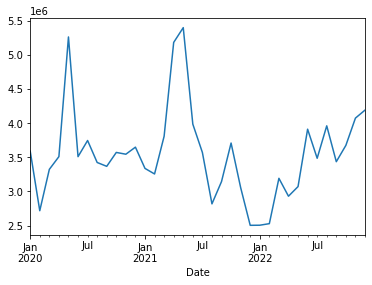

In [26]:

Level_4_df['Level_4'].plot()

In [27]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(Level_4_df['Level_4'],order=(0,0,2))
model_fit=model.fit()
model_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                Level_4   No. Observations:                   36
Model:                     ARMA(0, 2)   Log Likelihood                -527.315
Method:                       css-mle   S.D. of innovations         549683.148
Date:                Thu, 29 Dec 2022   AIC                           1062.630
Time:                        13:20:42   BIC                           1068.964
Sample:                    01-01-2020   HQIC                          1064.840
                         - 12-01-2022                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.553e+06    1.9e+05     18.725      0.000    3.18e+06    3.93e+06
ma.L1.Level_4     0.5717      0.131      4.378      0.000       0.316       0.828
ma.L2.Level_4     0.5390      0.260      2.070      0.038       0.029       1.049
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.5303           -1.2546j            1.3620           -0.3136
MA.2           -0.5303           +1.2546j            1.3620            0.3136
-----------------------------------------------------------------------------
"""

In [28]:
df_predict = pd.DataFrame(model_fit.predict(start=36,end=47,dynamic=True),columns = ['forecast'])

In [29]:
df_predict

,forecast
2023-01-01,4.018212e+06
2023-02-01,3.721582e+06
2023-03-01,3.553277e+06
2023-04-01,3.553277e+06
2023-05-01,3.553277e+06
2023-06-01,3.553277e+06
2023-07-01,3.553277e+06
2023-08-01,3.553277e+06
2023-09-01,3.553277e+06
2023-10-01,3.553277e+06


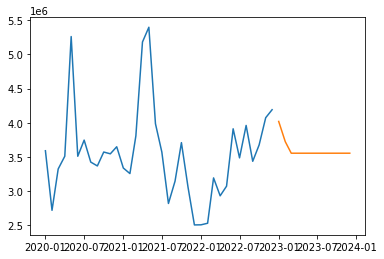

In [30]:
from matplotlib import pyplot as plt
plt.plot(Level_4_df)
plt.plot(df_predict)

In [31]:
df_test = cleaned_df.groupby(['Year','Place_in_India'])['Level_4'].sum().reset_index()

In [32]:
df_test

,Year,Place_in_India,Level_4
0,2020,Bengaluru,3231524
1,2020,Dehradun,3685750
2,2020,Hyderabad,5156066
3,2020,Indore,20092071
4,2020,Pune,11039977
5,2021,Bengaluru,3140030
6,2021,Dehradun,2445091
7,2021,Hyderabad,7836311
8,2021,Indore,17533698
9,2021,Pune,12805835


# Part 5: Visualization

A line graph for “Level 2” for the different “Place_in_India?” over the months of the year 2020 & 2021.
 (Hint: On x-axis, there should be months for 2020 & 2021 and Y axis should be “Level 2” and there should be different lines depicting different regions of  “Place_in_India?”)


In [33]:
cleaned_df_agg = cleaned_df.groupby(['Date','Place_in_India'])['Level_2'].sum().reset_index()

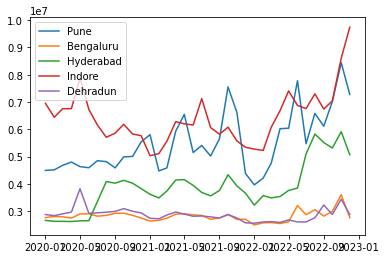

In [34]:
Place_in_India = set(cleaned_df_agg['Place_in_India'])

plt.figure()
for Place in Place_in_India:
    selected_data = cleaned_df_agg.loc[cleaned_df_agg['Place_in_India'] == Place]
    plt.plot(selected_data['Date'], selected_data['Level_2'], label=Place)
     
plt.legend()
plt.show()

⦁	A line graph for “Level 1” for the different “Laptop/Desktop” over the months of the year 2020 & 2021. 
 (Hint : On x axis there should be months from Jan- 2020 to Dec- 2021 and Y axis should be the sum of “Level 1” and there should be different lines depicting different devices used.)


In [35]:
# TO DO 

⦁	A line graph for “Level 1”, “Level 4”  and “inc/dec percentage” columns over the months of the year 2020, 2021 & 2022.

In [36]:
cleaned_df_agg_2 = cleaned_df.groupby('Date')['Level_1','Level_4','inc/dec percentage'].mean().reset_index()

C:\Users\Sanjeev\AppData\Local\Temp/ipykernel_9616/2558558590.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cleaned_df_agg_2 = cleaned_df.groupby('Date')['Level_1','Level_4','inc/dec percentage'].mean().reset_index()


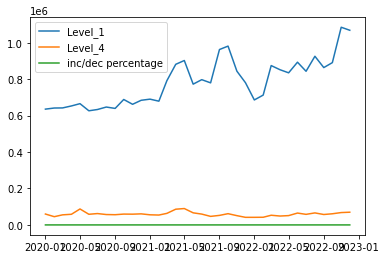

In [37]:
list1 = ['Level_1','Level_4','inc/dec percentage']

plt.figure()
for i in list1:
    plt.plot(cleaned_df_agg_2['Date'], cleaned_df_agg_2[i], label=i)
     
plt.legend()
plt.show()

⦁	A line graph for “Level 3” and “Place_in_India” over the months of the year 2020 and 2021.

In [38]:
# Same as above

⦁	A well visualized bar graph showing the “Level 1” from various places in India , also, representing the type of customers, for the year 2022.

In [39]:
cleaned_df_2020 = cleaned_df[cleaned_df['Year']==2020]

In [40]:
# Pivot Table
cleaned_df_agg_3  = cleaned_df_2020.pivot_table(values = 'Level_1', index = 'Place_in_India', columns = 'Type_of_Customers',aggfunc='sum' )

In [41]:
cleaned_df_agg_3

Type_of_Customers,Existing_Customer,New_Customer
Place_in_India,,
Bengaluru,5.643866e+07,13302335.0
Dehradun,5.643866e+07,18618773.0
Hyderabad,5.643866e+07,21907018.0
Indore,5.643866e+07,75183810.0
Pune,5.576402e+07,58736981.0


In [42]:
cleaned_df_2020

,Year,Month,Laptop/Desktop,Type_of_Customers,Coming from,Place_in_India,Level_1,Level_2,Level_3,Level_4,inc/dec percentage,Date
0,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Bengaluru,783870.222017,358215.416281,56892,17178,85.886489,2020-01-01
1,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Hyderabad,783870.222017,358215.416281,41460,11916,85.886489,2020-01-01
2,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Dehradun,783870.222017,358215.416281,55561,19461,85.886489,2020-01-01
3,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Indore,783870.222017,358215.416281,320923,110667,85.886489,2020-01-01
4,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Pune,783870.222017,358215.416281,220937,46033,85.886489,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
715,2020,December,Laptop_Website,New_Customer,Unidentified_Sources,Bengaluru,64621.000000,37389.000000,9755,4784,92.596834,2020-12-01
716,2020,December,Laptop_Website,New_Customer,Unidentified_Sources,Hyderabad,177018.000000,123778.000000,37520,16502,90.677784,2020-12-01
717,2020,December,Laptop_Website,New_Customer,Unidentified_Sources,Dehradun,76343.000000,56429.000000,14623,8676,88.635500,2020-12-01
718,2020,December,Laptop_Website,New_Customer,Unidentified_Sources,Indore,530446.000000,309159.000000,156611,49842,90.603756,2020-12-01


In [43]:
cleaned_df_agg_3 = cleaned_df_agg_3.reset_index()

In [44]:
cleaned_df_agg_3

Type_of_Customers,Place_in_India,Existing_Customer,New_Customer
0,Bengaluru,5.643866e+07,13302335.0
1,Dehradun,5.643866e+07,18618773.0
2,Hyderabad,5.643866e+07,21907018.0
3,Indore,5.643866e+07,75183810.0
4,Pune,5.576402e+07,58736981.0


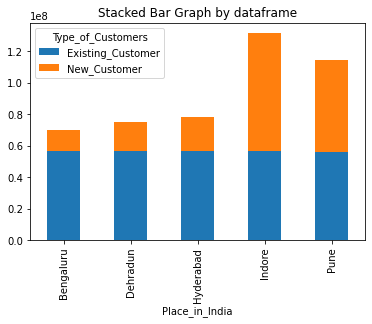

In [45]:
# plot data in stack manner of bar type
cleaned_df_agg_3.plot(x='Place_in_India', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe')
plt.show()

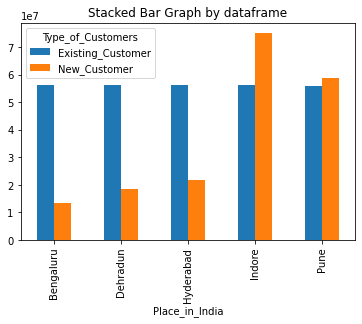

In [50]:
# plot data in un-stack manner of bar type
cleaned_df_agg_3.plot(x='Place_in_India', kind='bar', stacked=False,
        title='Stacked Bar Graph by dataframe')
plt.show()

In [61]:
# Cross Check 

In [55]:
cleaned_df_2020[(cleaned_df_2020['Place_in_India']=='Bengaluru') & (cleaned_df_2020['Type_of_Customers']=='Existing_Customer')]['Level_1'].sum()

56438655.98519889

In [60]:
cleaned_df_2020[(cleaned_df_2020['Place_in_India']=='Indore') & (cleaned_df_2020['Type_of_Customers']=='Existing_Customer')]['Level_1'].sum()

56438655.98519889